Revisiting QAM data for all eyes (from EXER paper?). Data pulled from Layers_AllMyope_9_9_16_qvh_edits_11_26_16.xlsx, the page named 'Means Data'. So, including the CA sections. 

In [95]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from IPython.display import display
import matplotlib.colors as mcolors
import os

%matplotlib inline

# The specified .csv file comes from Layers_AllMyope_9_9_16_qvh_edits_11_26_16.xlsx, the sheet titled "Means Data"

in_fid = r'.\Stata_mean_all.csv'

in_data = pd.read_csv(in_fid)

in_data['alpha'] *= 1e6 # Convert to dB/MHz/cm

in_data.drop('absref',inplace=True,axis=1) # No need for the absolute refractive error. At least not for now

# Drop any rows for which the ROI is < 0.2mm away from ONH
in_data = in_data[in_data['ROI'] >= 0.2]

# Add a column to bin the ROIs
# The ROI bins are 0.6mm long, starting at 0.2mm from the ONH
#in_data['roi_bin'] = pd.cut(in_data['ROI'],[0.2,0.8, 1.4, 2, 2.6, 3.2, 3.8, 4.4, 10],labels=['0.2-0.8','0.8-1.4','1.4-2','2-2.6','2.6-3.2','3.2-3.8','3.8-4.4','4.4+'])
roi_bin = pd.cut(in_data['ROI'],[0.2,0.8, 1.4, 2, 2.6, 3.2, 10],labels=['0.2-0.8','0.8-1.4','1.4-2','2-2.6','2.6-3.2','3.2+'])
in_data['roi_bin'] = roi_bin
in_data['roi_bin_centers'] = in_data['roi_bin'].apply(lambda x: x.mid)

in_data.head() # quick inspection of the first five rows 

AttributeError: 'str' object has no attribute 'mid'

In [2]:
in_data.groupby('GP').count() # Gives a count of the number of data points for each GP

,relmyo,myolevel,Eye,Region,ROI,Layer,c,K,rho,alpha,Z,roi_bin
GP,,,,,,,,,,,,
11-3,163,163,163,163,163,163,163,163,163,163,163,163
12-1,160,160,160,160,160,160,160,160,160,160,160,160
12-2,20,20,20,20,20,20,20,20,20,20,20,20
12-4,68,68,68,68,68,68,68,68,68,68,68,68
24-3,28,28,28,28,28,28,28,28,28,28,28,28
39-2,8,8,8,8,8,8,8,8,8,8,8,8
9-1,52,52,52,52,52,52,52,52,52,52,52,52
9-2,8,8,8,8,8,8,8,8,8,8,8,8


In [3]:
in_data.groupby('roi_bin').count() # Gives a count of the number of data points for each ROI bin

,GP,relmyo,myolevel,Eye,Region,ROI,Layer,c,K,rho,alpha,Z
roi_bin,,,,,,,,,,,,
0.2-0.8,0,0,0,0,0,0,0,0,0,0,0,0
0.8-1.4,32,32,32,32,32,32,32,32,32,32,32,32
1.4-2,120,120,120,120,120,120,120,120,120,120,120,120
2-2.6,104,104,104,104,104,104,104,104,104,104,104,104
2.6-3.2,60,60,60,60,60,60,60,60,60,60,60,60
3.2+,191,191,191,191,191,191,191,191,191,191,191,191


In [4]:
in_data.describe() # provides a naive statistical summary of the data

,relmyo,ROI,Layer,c,K,rho,alpha,Z
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,3.148462,2.855621,2.497041,1660.571738,2.738781,1.004549,9.342165,1.652180
std,3.656831,1.000782,1.118251,110.360715,0.241423,0.038255,3.593676,0.078102
min,0.000000,1.200000,1.000000,1488.161696,2.396095,0.931050,0.490948,1.541316
25%,0.000000,2.000000,1.500000,1568.490008,2.541849,0.974168,6.757915,1.596790
50%,0.000000,2.600000,2.000000,1639.692405,2.672861,0.999104,9.220230,1.633308
75%,7.130000,3.800000,3.000000,1748.702999,2.933975,1.032429,11.775150,1.686140
max,9.290000,4.800000,4.000000,2091.749131,3.362391,1.132472,23.912900,1.972843


Check the number of data points in each ROI and within each ROI bin

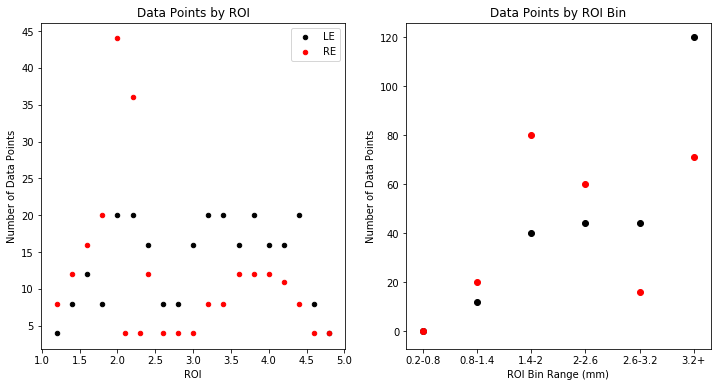

In [27]:
# Get the number of samples by ROI for each eye
le_data = in_data[in_data['Eye'] == 'LE']
re_data = in_data[in_data['Eye'] == 'RE']

le_count = le_data.groupby('ROI',as_index=False).count()
re_count = re_data.groupby('ROI',as_index=False).count()

# Plot against each other
this_fig, this_ax = plt.subplots(1,2,figsize=(12,6))
le_count.plot.scatter(x='ROI',y='Z',color='black',label='LE',ax=this_ax[0])
re_count.plot.scatter(x='ROI',y='Z',color='red',label='RE',ax=this_ax[0])

this_ax[0].set_ylabel('Number of Data Points')
this_ax[0].set_title('Data Points by ROI')

# Repeat, but perform the count by bin
le_count = le_data.groupby('roi_bin',as_index=False).count()
re_count = re_data.groupby('roi_bin',as_index=False).count()

#le_count.plot.scatter(x='roi_bin',y='Z',color='black',label='LE',ax=this_ax[1])
#re_count.plot.scatter(x='roi_bin',y='Z',color='red',label='RE',ax=this_ax[1])
this_ax[1].scatter(le_count['roi_bin'].values,le_count['Z'].values,color='black',label='LE')
this_ax[1].scatter(re_count['roi_bin'].values,re_count['Z'].values,color='red',label='RE')

this_ax[1].set_ylabel('Number of Data Points')
this_ax[1].set_title('Data Points by ROI Bin')
this_ax[1].set_xlabel('ROI Bin Range (mm)')

this_fig.savefig(r'.\roi_data_counts.png',dpi=200)

In [21]:
le_count['roi_bin'].values

[0.2-0.8, 0.8-1.4, 1.4-2, 2-2.6, 2.6-3.2, 3.2+]
Categories (6, object): [0.2-0.8 < 0.8-1.4 < 1.4-2 < 2-2.6 < 2.6-3.2 < 3.2+]

Start statistical comparison of the acoustic parameters by region. I'll start with independent sample t-tests to compare the mean parameter values between Inf/Sup, LE/RE, and combinations of the two.

,Diff (Inf-Sup),t-values,p-values
c,-30.7224,-3.0656,0.0023
K,-0.0532,-2.4201,0.0159
rho,0.0065,1.8720,0.0618
alpha,0.2643,0.8031,0.4223
Z,-0.0200,-2.8203,0.0050


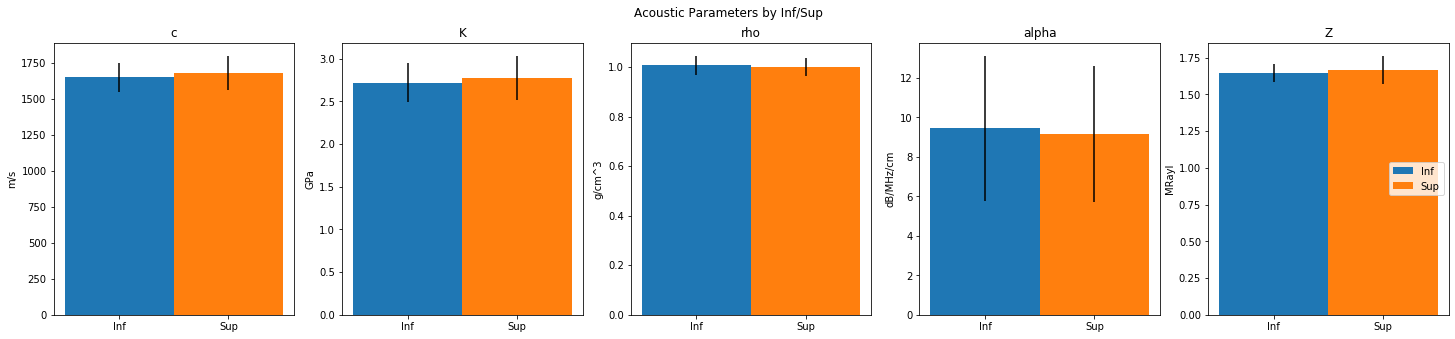

In [35]:
# Start comparing the parameter values. First, Inf vs Sup
param_list = ['c','K','rho','alpha','Z'] # List of parameters for comparison
units_list = ['m/s','GPa','g/cm^3','dB/MHz/cm','MRayl']
num_param = len(param_list)

this_fig,this_ax = plt.subplots(1,num_param,figsize=((5*num_param),5))
this_ax = this_ax.ravel()

# First, for all eyes, compare parameters in Inf vs Sup
inf_data = in_data[in_data['Region'] == 'INF']
sup_data = in_data[in_data['Region'] == 'SUP']

param_diff = np.zeros((num_param,3)) # column 1 is mean diff, column 2 is t-values, column 3 is p-values

for pp in range(num_param):
    this_param = param_list[pp]
    this_t, this_p = scipy.stats.ttest_ind(inf_data[this_param],sup_data[this_param])
    this_diff = inf_data[this_param].mean() - sup_data[this_param].mean()
    param_diff[pp,:] = [this_diff,this_t,this_p]

    p_x = [this_param, this_param]
    p_y = [inf_data[this_param].mean(), sup_data[this_param].mean()]
    p_err = [inf_data[this_param].std(), sup_data[this_param].std()]

    b_width = 0.35
    this_ax[pp].bar(x=-b_width/2,height=p_y[0],width=b_width,label='Inf',yerr=p_err[0],color='tab:blue')
    this_ax[pp].bar(x=+b_width/2,height=p_y[1],width=b_width,label='Sup',yerr=p_err[1],color='tab:orange')
    this_ax[pp].set_title(this_param)
    this_ax[pp].set_ylabel(units_list[pp])
    this_ax[pp].set_xticks([-b_width/2,b_width/2])
    this_ax[pp].set_xticklabels(['Inf','Sup'])

this_ax[-1].legend(loc='center right')
this_fig.suptitle('Acoustic Parameters by Inf/Sup')

this_fig.savefig(r'.\inf_sup_comp.png',dpi=150)

# Create a DataFrame from the t-test results
this_df = pd.DataFrame(param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)
display(this_df)

The results of the t-tests (and illustrated by the bar charts):
    Grouping all eyes, the parameters c, K, and Z are significantly different between Inf and Sup

LE                                  RE                     
      Diff (Inf-Sup) t-values    p-values Diff (Inf-Sup) t-values    p-values
c           -26.1188  -1.7947  7.3868e-02       -35.3351  -2.4107  1.6661e-02
K            -0.0887  -2.8554  4.6478e-03        -0.0099  -0.2973  7.6650e-01
rho          -0.0127  -2.9030  4.0158e-03         0.0326   5.8913  1.2592e-08
alpha         0.0060   0.0152  9.8785e-01         0.8196   1.4225  1.5614e-01
Z            -0.0543  -5.1430  5.3524e-07         0.0282   3.0611  2.4510e-03

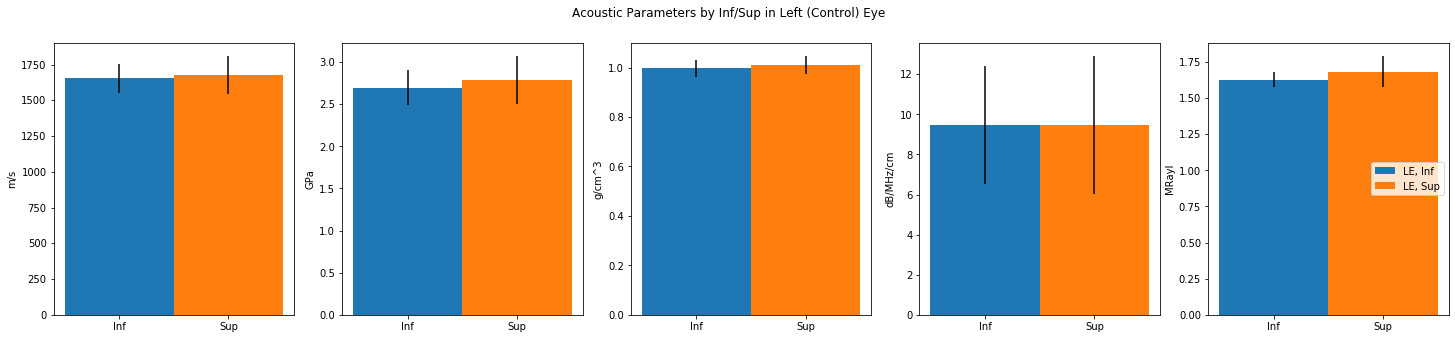

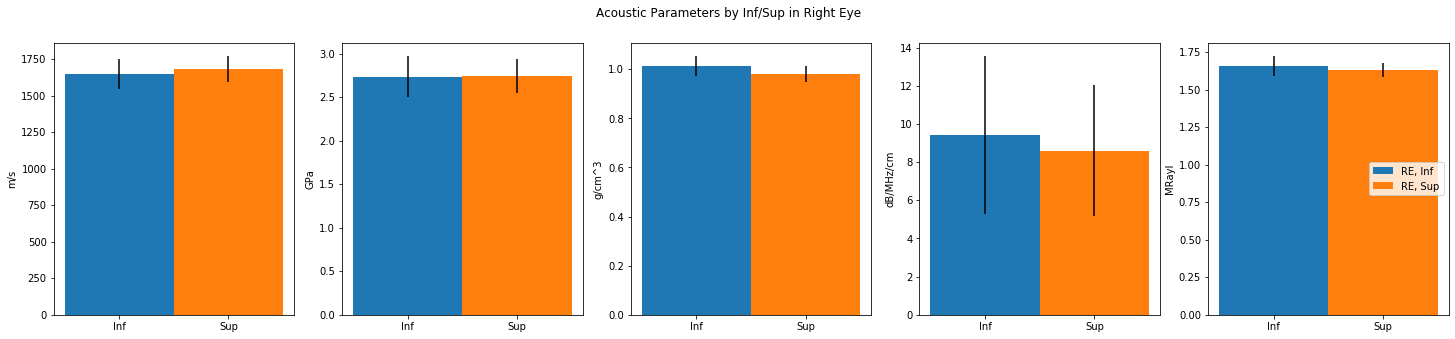

In [40]:
# Repeat the Inf-Sup comparisons for LE and RE individually. Then compare LE-RE for Inf and Sup
le_param_diff = np.zeros((num_param,3))
re_param_diff = np.zeros((num_param,3))

le_inf_data = le_data[le_data['Region'] == 'INF']
le_sup_data = le_data[le_data['Region'] == 'SUP']
re_inf_data = re_data[re_data['Region'] == 'INF']
re_sup_data = re_data[re_data['Region'] == 'SUP']

le_fig, le_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
re_fig, re_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))

le_fig.suptitle('Acoustic Parameters by Inf/Sup in Left (Control) Eye')
re_fig.suptitle('Acoustic Parameters by Inf/Sup in Right Eye')


le_ax = le_ax.ravel()
re_ax = re_ax.ravel()

for pp in range(num_param):
    this_param = param_list[pp]
    
    # t-test for left eye first
    this_t, this_p = scipy.stats.ttest_ind(le_inf_data[this_param],le_sup_data[this_param])
    this_diff = le_inf_data[this_param].mean() - le_sup_data[this_param].mean()
    le_param_diff[pp,:] = [this_diff, this_t, this_p]

    # Plot the mean values with std as error bars
    b_width = 0.35
    p_y = [le_inf_data[this_param].mean(), le_sup_data[this_param].mean()]
    p_err = [le_inf_data[this_param].std(), le_sup_data[this_param].std()]
    le_ax[pp].bar(x=-b_width/2,height=p_y[0],yerr=p_err[0],width=b_width,label='LE, Inf',color='tab:blue')
    le_ax[pp].bar(x=+b_width/2,height=p_y[1],yerr=p_err[1],width=b_width,label='LE, Sup',color='tab:orange')
    le_ax[pp].set_ylabel(units_list[pp])
    le_ax[pp].set_xticks([-b_width/2,b_width/2])
    le_ax[pp].set_xticklabels(['Inf','Sup'])

    # t-test for right eye
    this_t, this_p = scipy.stats.ttest_ind(re_inf_data[this_param],re_sup_data[this_param])
    this_diff = re_inf_data[this_param].mean() - re_sup_data[this_param].mean()
    re_param_diff[pp,:] = [this_diff,this_t,this_p]
    
    # Plot the mean values for the right eye with std as error bars
    p_y = [re_inf_data[this_param].mean(), re_sup_data[this_param].mean()]
    p_err = [re_inf_data[this_param].std(), re_sup_data[this_param].std()]
    re_ax[pp].bar(x=-b_width/2,height=p_y[0],yerr=p_err[0],width=b_width,label='RE, Inf',color='tab:blue')
    re_ax[pp].bar(x=+b_width/2,height=p_y[1],yerr=p_err[1],width=b_width,label='RE, Sup',color='tab:orange')
    re_ax[pp].set_ylabel(units_list[pp])
    re_ax[pp].set_xticks([-b_width/2,b_width/2])
    re_ax[pp].set_xticklabels(['Inf','Sup'])

le_ax[-1].legend(loc='center right')
re_ax[-1].legend(loc='center right')

le_fig.savefig(r'.\inf_sup_le_comp.png',dpi=200)
re_fig.savefig(r'.\inf_sup_re_comp.png',dpi=200)

# Create DataFrames for the LE and RE summaries, this combine into one with a MultiIndex to summarize more concisely
le_df = pd.DataFrame(le_param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)
re_df = pd.DataFrame(re_param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)

le_df.columns = pd.MultiIndex.from_product([['LE'], le_df.columns])
re_df.columns = pd.MultiIndex.from_product([['RE'], re_df.columns])
full_df = pd.concat([le_df, re_df],axis=1)

pd.set_option('precision',4)
full_df


This time, intra-eye comparisons between Inf and Sup

For LE:
    - K, rho, Z are significantly different between Inf and Sup

For RE:
    - c, rho, Z are significantly different between Inf and Sup

INF                            SUP                     
      Diff (LE-RE) t-values p-values Diff (LE-RE) t-values    p-values
c           6.1848   0.5234   0.6011      -3.0314  -0.1663  8.6812e-01
K          -0.0372  -1.4371   0.1517       0.0417   1.0446  2.9753e-01
rho        -0.0168  -3.9146   0.0001       0.0286   5.2743  3.6083e-07
alpha       0.0521   0.1238   0.9015       0.8656   1.6437  1.0190e-01
Z          -0.0273  -3.8590   0.0001       0.0552   3.8651  1.5235e-04

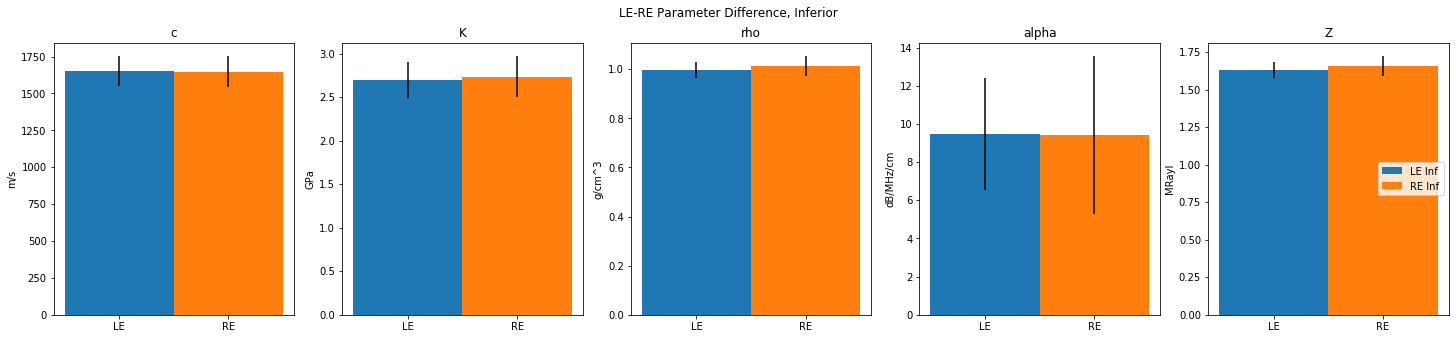

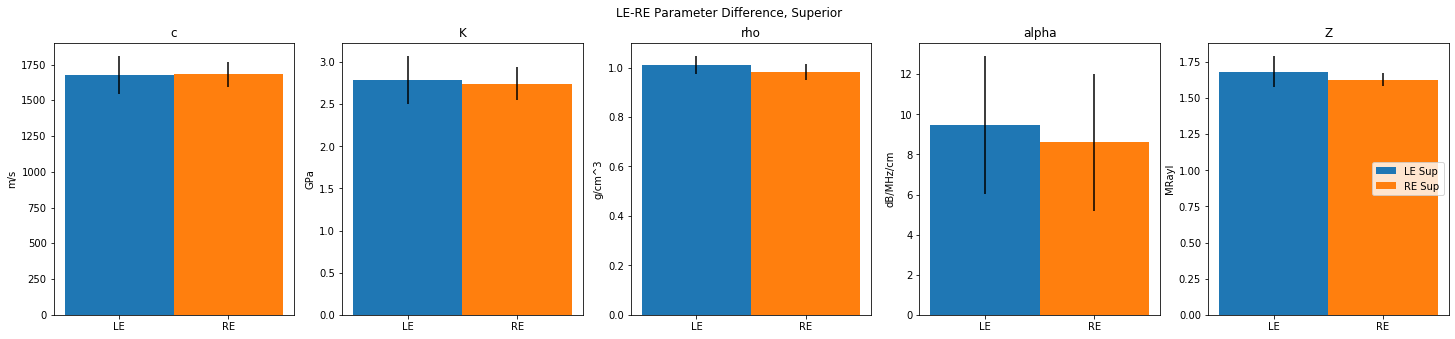

In [42]:
# This time, compare the Inf and Sup regions between LE and RE

inf_param_diff = np.zeros((num_param,3))
sup_param_diff = np.zeros((num_param,3))

inf_fig, inf_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
sup_fig, sup_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))

inf_fig.suptitle('LE-RE Parameter Difference, Inferior')
sup_fig.suptitle('LE-RE Parameter Difference, Superior')

inf_ax = inf_ax.ravel()
sup_ax = sup_ax.ravel()

for pp in range(num_param):
    this_param = param_list[pp]

    # Compare INF regions between LE and RE
    this_t, this_p = scipy.stats.ttest_ind(le_inf_data[this_param],re_inf_data[this_param])
    this_diff = le_inf_data[this_param].mean() - re_inf_data[this_param].mean()
    inf_param_diff[pp,:] = [this_diff,this_t,this_p]

    bar_width = 0.35
    p_x = [-bar_width/2, +bar_width/2]
    p_y = [le_inf_data[this_param].mean(), re_inf_data[this_param].mean()]
    p_err = [le_inf_data[this_param].std(), re_inf_data[this_param].std()]
    inf_ax[pp].bar(x=p_x[0],height=p_y[0],yerr=p_err[0],width=b_width,label='LE Inf',color='tab:blue')
    inf_ax[pp].bar(x=p_x[1],height=p_y[1],yerr=p_err[1],width=b_width,label='RE Inf',color='tab:orange')
    inf_ax[pp].set_title(this_param)
    inf_ax[pp].set_xticks(p_x)
    inf_ax[pp].set_xticklabels(['LE','RE'])
    inf_ax[pp].set_ylabel(units_list[pp])

    # Now compare SUP regions
    this_t, this_p = scipy.stats.ttest_ind(le_sup_data[this_param],re_sup_data[this_param])
    this_diff = le_sup_data[this_param].mean() - re_sup_data[this_param].mean()
    sup_param_diff[pp,:] = [this_diff,this_t,this_p]

    p_y = [le_sup_data[this_param].mean(), re_sup_data[this_param].mean()]
    p_err = [le_sup_data[this_param].std(), re_sup_data[this_param].std()]
    sup_ax[pp].bar(x=p_x[0],height=p_y[0],yerr=p_err[0],width=b_width,label='LE Sup',color='tab:blue')
    sup_ax[pp].bar(x=p_x[1],height=p_y[1],yerr=p_err[1],width=b_width,label='RE Sup',color='tab:orange')
    sup_ax[pp].set_title(this_param)
    sup_ax[pp].set_xticks(p_x)
    sup_ax[pp].set_xticklabels(['LE','RE'])
    sup_ax[pp].set_ylabel(units_list[pp])

inf_ax[-1].legend(loc='center right')
sup_ax[-1].legend(loc='center right')

inf_fig.savefig(r'.\le-re_diff_inf.png',dpi=200)
sup_fig.savefig(r'.\le-re_diff_sup.png',dpi=200)

# As before, create DataFrames and concatenate with MultiIndex to create a concise summary
inf_df = pd.DataFrame(inf_param_diff,columns=['Diff (LE-RE)','t-values','p-values'],index=param_list)
sup_df = pd.DataFrame(sup_param_diff,columns=['Diff (LE-RE)','t-values','p-values'],index=param_list)

inf_df.columns = pd.MultiIndex.from_product([['INF'], inf_df.columns])
sup_df.columns = pd.MultiIndex.from_product([['SUP'], sup_df.columns])

full_df = pd.concat([inf_df,sup_df],axis=1)

full_df

Comparing the Inf and Sup regions between LE and RE:

Inf: 
    - rho and Z are significantly smaller in the LE

Sup:
    - rho and Z are significantly larger in the LE

,f-stat,p-value
c,168.6849,1.1592e-75
K,152.8860,2.0333e-70
rho,77.7356,2.5089e-41
alpha,66.3122,3.8207e-36
Z,50.5151,1.4929e-28


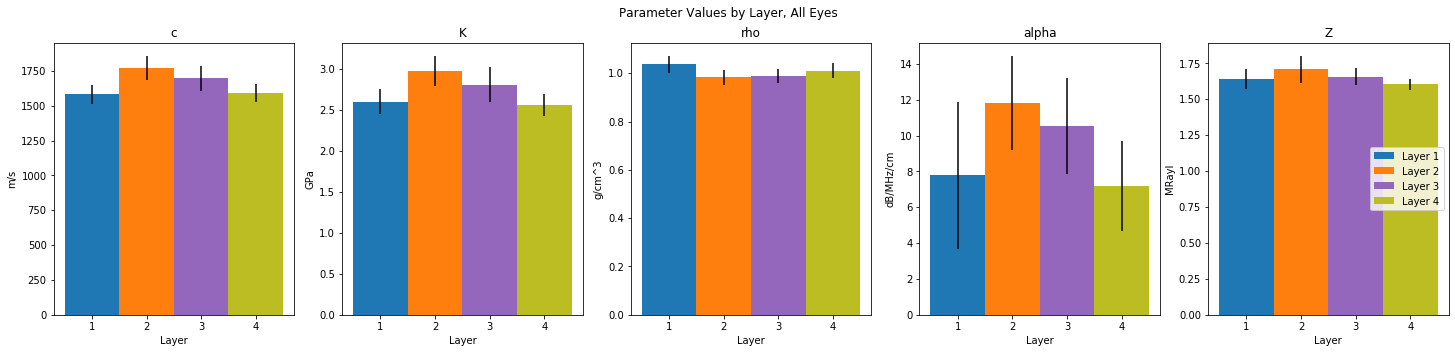

In [45]:
# Before starting to repeat some of the above on a per-layer basis, look for a difference in the parameters by layer generally
# Use ANOVA to determine if any of them differ
# Look at all eyes, then split into Inf/Sup and then further into LE/RE

fstats_all = np.zeros((num_param,2))

layer_fig, layer_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
b_width = 0.35/4
p_x = [-3*b_width/2, -b_width/2, b_width/2, 3*b_width/2]

layer_fig.suptitle('Parameter Values by Layer, All Eyes')

color_list = ['tab:blue','tab:orange','tab:purple','tab:olive']

for pp, this_param in enumerate(param_list):
    this_fstat, this_p = scipy.stats.f_oneway(in_data[this_param][in_data['Layer'] == 1],
            in_data[this_param][in_data['Layer'] == 2],
            in_data[this_param][in_data['Layer'] == 3],
            in_data[this_param][in_data['Layer'] == 4])
    
    for ii in range(4):
        this_data = in_data[this_param][in_data['Layer'] == (ii+1)]
        p_y = this_data.mean()
        p_err = this_data.std()
        layer_ax[pp].bar(x=p_x[ii],height=p_y,yerr=p_err,width=b_width,label=f'Layer {ii+1}',color=color_list[ii])

    layer_ax[pp].set_xticks(p_x)
    layer_ax[pp].set_xticklabels(['1','2','3','4'])
        
    layer_ax[pp].set_title(this_param)
    layer_ax[pp].set_ylabel(units_list[pp])
    layer_ax[pp].set_xlabel('Layer')

    fstats_all[pp,:] = this_fstat, this_p

layer_ax[-1].legend(loc='center right')

layer_fig.savefig(r'.\layer_fig.png',dpi=200)

fstats_all_df = pd.DataFrame(fstats_all,columns=['f-stat','p-value'],index=param_list)
fstats_all_df

The ANOVA comparing the acoustic parameter values across the four scleral layers (all eyes) indicates at least one exhibits a different mean value. Based on the bar charts, it looks like the inner two layers have similar means, the outer two layers have similar means, and the inner and outer layers differ significantly.

In [12]:
# ANOVA by LE/RE
fstats_le = np.zeros((num_param,2))
fstats_re = np.zeros((num_param,2))

for pp, this_param in enumerate(param_list):
    this_data = le_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le[pp,:] = [this_fstat, this_p]

    this_data = re_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re[pp,:] = [this_fstat, this_p]

fstats_le_df = pd.DataFrame(fstats_le,columns=['f-stat','p-value'],index=param_list)
fstats_re_df = pd.DataFrame(fstats_re,columns=['f-stat','p-value'],index=param_list)

fstats_le_df.columns = pd.MultiIndex.from_product([['LE'], fstats_le_df.columns])
fstats_re_df.columns = pd.MultiIndex.from_product([['RE'], fstats_re_df.columns])

fstats_lere_df = pd.concat([fstats_le_df,fstats_re_df],axis=1)
fstats_lere_df

LE                   RE            
        f-stat     p-value   f-stat     p-value
c      96.6979  7.1771e-42  75.7207  1.2974e-34
K      82.1303  2.9904e-37  71.2484  4.3049e-33
rho    42.3652  2.9008e-22  37.1131  8.8155e-20
alpha  27.2294  2.5646e-15  39.6744  6.6497e-21
Z      28.3969  6.9517e-16  23.5323  2.0904e-13

Looking at intra-eye comparisons of the layers, we find
    - All parameters differ significantly in at least two layers (p < 0.05)

In [13]:
# ANOVA by LE/RE split further by Inf/Sup

fstats_le_inf = np.zeros((num_param,2))
fstats_re_inf = np.zeros((num_param,2))
fstats_le_sup = np.zeros((num_param,2))
fstats_re_sup = np.zeros((num_param,2))

for pp, this_param in enumerate(param_list):
    this_data = le_inf_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le_inf[pp,:] = [this_fstat, this_p]

    this_data = re_inf_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re_inf[pp,:] = [this_fstat, this_p]

    this_data = le_sup_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le_sup[pp,:] = [this_fstat, this_p]

    this_data = re_sup_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re_sup[pp,:] = [this_fstat, this_p]

fstats_leinf_df = pd.DataFrame(fstats_le_inf,columns=['f-stat','p-value'],index=param_list)
fstats_reinf_df = pd.DataFrame(fstats_re_inf,columns=['f-stat','p-value'],index=param_list)
fstats_lesup_df = pd.DataFrame(fstats_le_sup,columns=['f-stat','p-value'],index=param_list)
fstats_resup_df = pd.DataFrame(fstats_re_sup,columns=['f-stat','p-value'],index=param_list)

fstats_leinf_df.columns = pd.MultiIndex.from_product([['LE INF'], fstats_leinf_df.columns])
fstats_reinf_df.columns = pd.MultiIndex.from_product([['RE INF'], fstats_reinf_df.columns])
fstats_lesup_df.columns = pd.MultiIndex.from_product([['LE SUP'], fstats_lesup_df.columns])
fstats_resup_df.columns = pd.MultiIndex.from_product([['RE SUP'], fstats_resup_df.columns])

fstats_lere_reg_df = pd.concat([fstats_leinf_df,fstats_lesup_df,fstats_reinf_df,fstats_resup_df],axis=1)
fstats_lere_reg_df

LE INF               LE SUP               RE INF               RE SUP  \
        f-stat     p-value   f-stat     p-value   f-stat     p-value   f-stat   
c      40.1846  2.2856e-18  64.2036  4.0279e-25  49.8633  1.7862e-23  40.8079   
K      34.8843  1.5161e-16  57.4292  2.4093e-23  46.4017  3.1030e-22  37.7373   
rho    31.3390  2.9422e-15  18.2153  7.4171e-10  28.9003  2.7481e-15  21.5976   
alpha  15.5326  1.1249e-08  13.2775  1.4252e-07  24.6589  2.1064e-13  24.6165   
Z      11.8938  6.3721e-07  24.0927  2.3671e-12  18.7510  1.2732e-10  10.2580   

                   
          p-value  
c      1.6799e-14  
K      7.8509e-14  
rho    1.3160e-09  
alpha  1.6553e-10  
Z      1.5145e-05

Continuing the intra-eye comparisons, this time splitting further into Inf and Sup
Still find that at least two layers in each of the four regions (LE INF, LE SUP, RE INF, RE SUP) exhibit significantly different mean parameter values

In [14]:
# The ANOVA for each case indicates that parameters in at least one of the layers has a different mean value when compared to the other layers for all parameters
# Now, compare the Inf/Sup values in each layer over all eyes, intra-eye (LE/RE), and inter-eye (LE-RE)

# First, over all eyes
num_layers = 4
layer_diff = {} # Going to make use of dictionary

for pp, this_param in enumerate(param_list):
    temp_diff_mat = np.zeros((num_layers,3))
    for ll in range(num_layers):
        this_inf_data = inf_data[inf_data['Layer'] == (ll+1)][this_param]
        this_sup_data = sup_data[sup_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_inf_data,this_sup_data)
        this_diff = this_inf_data.mean() - this_sup_data.mean()
        temp_diff_mat[ll,:] = [this_diff,this_t,this_p]

    layer_diff[this_param] = temp_diff_mat.copy()

# Create a DataFrame for each entry in the layer_diff dictionary, then concatenate all to concisely summarize
df_list = []
for pp, this_param in enumerate(param_list):
    this_df = pd.DataFrame(layer_diff[this_param],columns=['Inf-Sup','t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    df_list.append(this_df)

full_df = pd.concat(df_list,axis=1)
full_df


c                           K                     rho          \
   Inf-Sup  t-stat     p-value Inf-Sup  t-stat p-value Inf-Sup  t-stat   
1   2.2351  0.1772  8.5962e-01  0.0182  0.6375  0.5250  0.0044  0.6885   
2 -62.8794 -4.2353  4.3874e-05 -0.1162 -3.5739  0.0005  0.0040  0.6802   
3 -37.0934 -2.2587  2.5634e-02 -0.0848 -2.2247  0.0279  0.0042  0.7995   
4 -26.0126 -2.3036  2.2910e-02 -0.0322 -1.2741  0.2050  0.0137  2.4529   

            alpha                       Z                  
  p-value Inf-Sup  t-stat p-value Inf-Sup  t-stat p-value  
1  0.4924  1.1920  1.5959  0.1130 -0.0030 -0.2328  0.8163  
2  0.4977  0.2442  0.5077  0.6125 -0.0559 -3.3824  0.0010  
3  0.4255  0.0947  0.1920  0.8481 -0.0231 -2.0968  0.0380  
4  0.0156 -0.5043 -1.0978  0.2744  0.0013  0.1882  0.8510

This time comparing parameters between Inf/Sup by layer. 
For legibility, I'll list the parameters that differ significantly by layer

    - Layer 1: none
    - Layer 2: c, K, Z
    - Layer 3: c, K, Z
    - Layer 4: c, rho

c                       K                         rho          \
      Inf-Sup  t-stat p-value Inf-Sup  t-stat     p-value Inf-Sup  t-stat   
LE 1  22.7522  1.5324  0.1304  0.0091  0.2330  8.1654e-01 -0.0197 -2.4028   
   2 -77.5840 -3.9911  0.0002 -0.2206 -6.4801  1.5953e-08 -0.0221 -3.3582   
   3 -29.7036 -1.0924  0.2788 -0.1000 -1.5981  1.1502e-01 -0.0111 -1.7018   
   4 -19.9399 -1.4661  0.1476 -0.0433 -1.5831  1.1840e-01  0.0020  0.2799   
RE 1 -17.3692 -0.7827  0.4369  0.0421  0.9312  3.5549e-01  0.0320  3.4790   
   2 -26.6062 -1.1289  0.2634  0.0381  0.6715  5.0446e-01  0.0379  4.0635   
   3 -50.6810 -2.7280  0.0083 -0.0804 -1.8173  7.4165e-02  0.0256  3.0371   
   4 -47.9822 -2.4894  0.0156 -0.0428 -0.9156  3.6361e-01  0.0351  3.9595   

               alpha                       Z                      
     p-value Inf-Sup  t-stat p-value Inf-Sup  t-stat     p-value  
LE 1  0.0192  1.0315  1.1544  0.2527 -0.0354 -1.8339  7.1391e-02  
   2  0.0013  0.1460  0.2820  0.7789 -0.1259 -5.7240  3.1097e-07  
   3  0.0937 -0.7988 -1.1003  0.2754 -0.0442 -2.5856  1.2048e-02  
   4  0.7804 -0.3545 -0.6158  0.5402 -0.0117 -1.5446  1.2745e-01  
RE 1  0.0009  2.1491  1.6491  0.1044  0.0433  2.7350  8.1902e-03  
   2  0.0001  0.0079  0.0088  0.9930  0.0519  2.5499  1.3346e-02  
   3  0.0035  1.2147  1.7584  0.0838  0.0016  0.1119  9.1124e-01  
   4  0.0002 -0.1540 -0.2006  0.8417  0.0150  1.1313  2.6251e-01

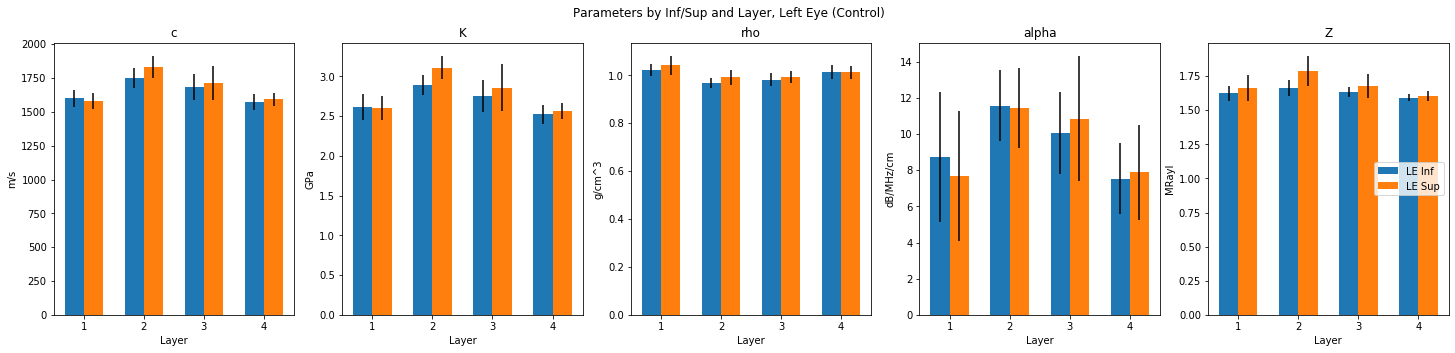

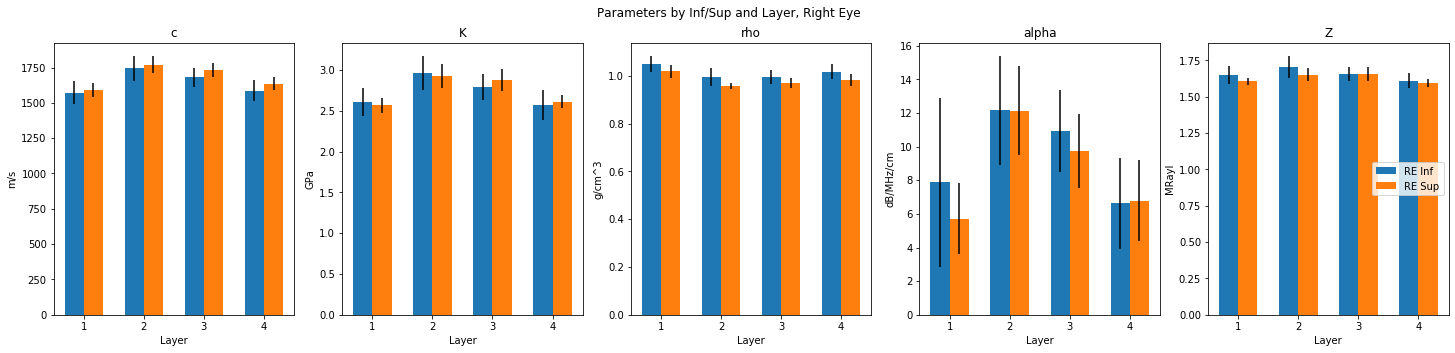

In [55]:
# Next, intra-eye differences
num_layers = 4
intra_le_diff = {} # Going to make use of dictionary
intra_re_diff = {}

b_width = 0.32
x_l = [1-b_width/2,2-b_width/2,3-b_width/2,4-b_width/2]
x_r = [1+b_width/2,2+b_width/2,3+b_width/2,4+b_width/2]

le_fig, le_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
re_fig, re_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))

le_fig.suptitle('Parameters by Inf/Sup and Layer, Left Eye (Control)')
re_fig.suptitle('Parameters by Inf/Sup and Layer, Right Eye')

le_ax = le_ax.ravel()
re_ax = re_ax.ravel()

for pp, this_param in enumerate(param_list):
    temp_le_diff_mat = np.zeros((num_layers,3))
    temp_re_diff_mat = np.zeros((num_layers,3))
    for ll in range(num_layers):
        this_inf_data = le_inf_data[le_inf_data['Layer'] == (ll+1)][this_param]
        this_sup_data = le_sup_data[le_sup_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_inf_data,this_sup_data)
        this_diff = this_inf_data.mean() - this_sup_data.mean()
        temp_le_diff_mat[ll,:] = [this_diff,this_t,this_p]

        this_ax = le_ax[pp]
        p_y = [this_inf_data.mean(), this_sup_data.mean()]
        p_err = [this_inf_data.std(), this_sup_data.std()]

        this_ax.bar(x=x_l[ll],height=p_y[0],yerr=p_err[0],width=b_width,color='tab:blue',label=f'LE Inf, Layer {ll+1}')
        this_ax.bar(x=x_r[ll],height=p_y[1],yerr=p_err[1],width=b_width,color='tab:orange',label=f'LE Sup, Layer {ll+1}')
        this_ax.set_title(this_param)


        this_inf_data = re_inf_data[re_inf_data['Layer'] == (ll+1)][this_param]
        this_sup_data = re_sup_data[re_sup_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_inf_data,this_sup_data)
        this_diff = this_inf_data.mean() - this_sup_data.mean()
        temp_re_diff_mat[ll,:] = [this_diff,this_t,this_p]

        this_ax = re_ax[pp]
        p_y = [this_inf_data.mean(), this_sup_data.mean()]
        p_err = [this_inf_data.std(), this_sup_data.std()]

        this_ax.bar(x=x_l[ll],height=p_y[0],yerr=p_err[0],width=b_width,color='tab:blue',label=f'RE Inf, Layer {ll+1}')
        this_ax.bar(x=x_r[ll],height=p_y[1],yerr=p_err[1],width=b_width,color='tab:orange',label=f'RE Sup, Layer {ll+1}')
        this_ax.set_title(this_param)

    le_ax[pp].set_xticks([1,2,3,4])
    le_ax[pp].set_xticklabels(['1','2','3','4'])
    le_ax[pp].set_ylabel(units_list[pp])
    le_ax[pp].set_title(this_param)
    le_ax[pp].set_xlabel('Layer')

    re_ax[pp].set_xticks([1,2,3,4])
    re_ax[pp].set_xticklabels(['1','2','3','4'])
    re_ax[pp].set_ylabel(units_list[pp])
    re_ax[pp].set_title(this_param)
    re_ax[pp].set_xlabel('Layer')

    intra_le_diff[this_param] = temp_le_diff_mat.copy()
    intra_re_diff[this_param] = temp_re_diff_mat.copy()

le_ax[-1].legend(('LE Inf','LE Sup'),loc='center right')
re_ax[-1].legend(('RE Inf','RE Sup'),loc='center right')

le_fig.savefig(r'.\param_by_layer_le.png',dpi=200)
re_fig.savefig(r'.\param_by_layer_re.png',dpi=200)

# Create a DataFrame for each entry in the layer_diff dictionary, then concatenate all to concisely summarize
le_df_list = []
re_df_list = []
for pp, this_param in enumerate(param_list):
    this_df = pd.DataFrame(intra_le_diff[this_param],columns=['Inf-Sup','t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    le_df_list.append(this_df)

    this_df = pd.DataFrame(intra_re_diff[this_param],columns=['Inf-Sup','t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    re_df_list.append(this_df)

full_le_df = pd.concat(le_df_list,axis=1)
full_re_df = pd.concat(re_df_list,axis=1)

full_le_df.index = pd.MultiIndex.from_product([['LE'], full_le_df.index])
full_re_df.index = pd.MultiIndex.from_product([['RE'], full_re_df.index])

full_df = pd.concat([full_le_df,full_re_df],axis=0)

display(full_df)

Repeating the comparison of parameters between Inf/Sup by layer, this time splitting by eye. Again, for ease, will list the parameters that differ significantly by layer

LE

    - Layer 1: rho (and almost Z)
    - Layer 2: c, K, rho, Z
    - Layer 3: alpha, Z
    - Layer 4: rho, Z

RE

    - Layer 1: rho, Z
    - Layer 2: rho, Z
    - Layer 3: c, rho
    - Layer 4: c, rho

c                       K                         rho          \
       Inf-Sup  t-stat p-value Inf-Sup  t-stat     p-value Inf-Sup  t-stat   
INF 1  22.7522  1.5324  0.1304  0.0091  0.2330  8.1654e-01 -0.0197 -2.4028   
    2 -77.5840 -3.9911  0.0002 -0.2206 -6.4801  1.5953e-08 -0.0221 -3.3582   
    3 -29.7036 -1.0924  0.2788 -0.1000 -1.5981  1.1502e-01 -0.0111 -1.7018   
    4 -19.9399 -1.4661  0.1476 -0.0433 -1.5831  1.1840e-01  0.0020  0.2799   
SUP 1 -17.3692 -0.7827  0.4369  0.0421  0.9312  3.5549e-01  0.0320  3.4790   
    2 -26.6062 -1.1289  0.2634  0.0381  0.6715  5.0446e-01  0.0379  4.0635   
    3 -50.6810 -2.7280  0.0083 -0.0804 -1.8173  7.4165e-02  0.0256  3.0371   
    4 -47.9822 -2.4894  0.0156 -0.0428 -0.9156  3.6361e-01  0.0351  3.9595   

                alpha                       Z                      
      p-value Inf-Sup  t-stat p-value Inf-Sup  t-stat     p-value  
INF 1  0.0192  1.0315  1.1544  0.2527 -0.0354 -1.8339  7.1391e-02  
    2  0.0013  0.1460  0.2820  0.7789 -0.1259 -5.7240  3.1097e-07  
    3  0.0937 -0.7988 -1.1003  0.2754 -0.0442 -2.5856  1.2048e-02  
    4  0.7804 -0.3545 -0.6158  0.5402 -0.0117 -1.5446  1.2745e-01  
SUP 1  0.0009  2.1491  1.6491  0.1044  0.0433  2.7350  8.1902e-03  
    2  0.0001  0.0079  0.0088  0.9930  0.0519  2.5499  1.3346e-02  
    3  0.0035  1.2147  1.7584  0.0838  0.0016  0.1119  9.1124e-01  
    4  0.0002 -0.1540 -0.2006  0.8417  0.0150  1.1313  2.6251e-01

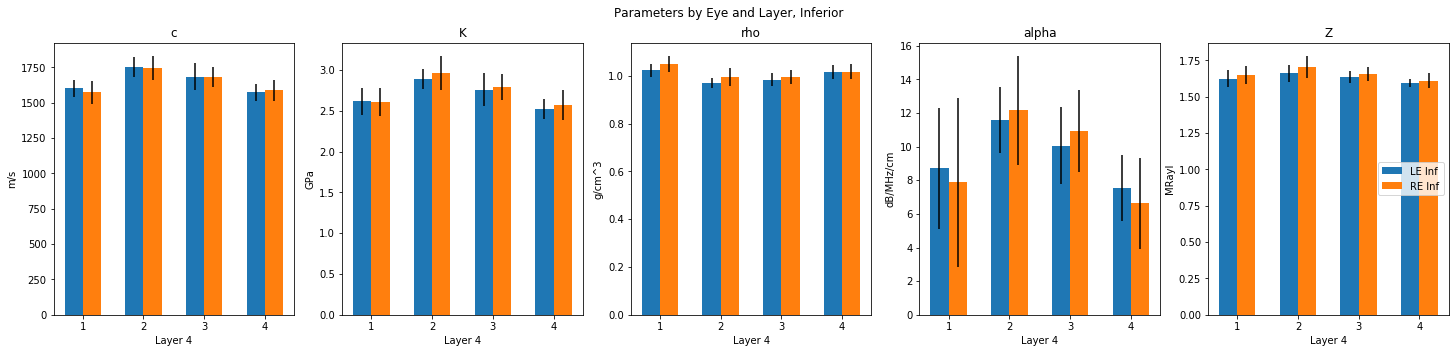

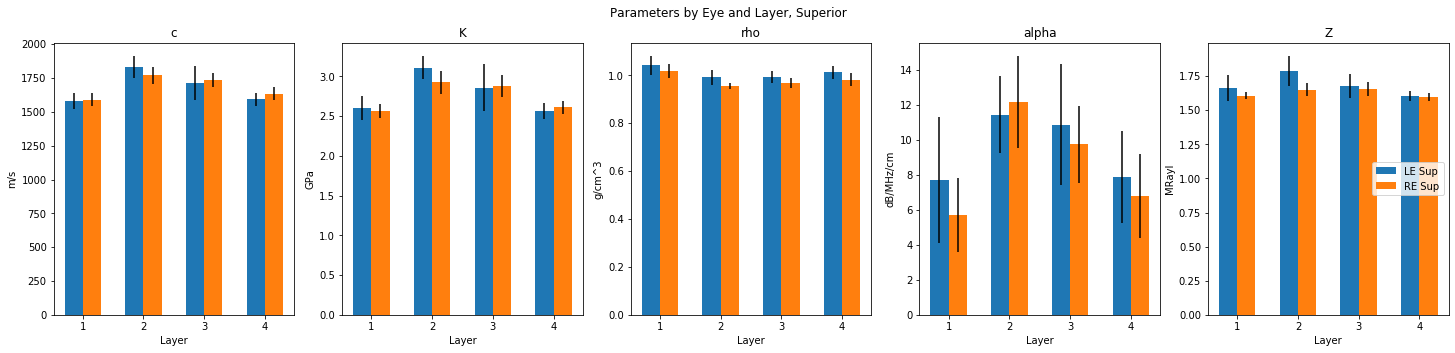

In [56]:
# Now compare Inf and Sup of LE-RE

num_layers = 4
inter_inf_diff = {} # Going to make use of dictionary
inter_sup_diff = {}

b_width = 0.3
x_l = [1-b_width/2,2-b_width/2,3-b_width/2,4-b_width/2]
x_r = [1+b_width/2,2+b_width/2,3+b_width/2,4+b_width/2]

inf_fig, inf_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
sup_fig, sup_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))

inf_fig.suptitle('Parameters by Eye and Layer, Inferior')
sup_fig.suptitle('Parameters by Eye and Layer, Superior')

inf_ax = inf_ax.ravel()
sup_ax = sup_ax.ravel()

for pp, this_param in enumerate(param_list):
    temp_inf_diff_mat = np.zeros((num_layers,3))
    temp_sup_diff_mat = np.zeros((num_layers,3))
    for ll in range(num_layers):
        this_le_data = le_inf_data[le_inf_data['Layer'] == (ll+1)][this_param]
        this_re_data = re_inf_data[re_inf_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_le_data,this_re_data)
        this_diff = this_le_data.mean() - this_re_data.mean()
        temp_inf_diff_mat[ll,:] = [this_diff, this_t, this_p]

        this_ax = inf_ax[pp]
        p_y = [this_le_data.mean(), this_re_data.mean()]
        p_err = [this_le_data.std(), this_re_data.std()]

        this_ax.bar(x=x_l[ll],height=p_y[0],yerr=p_err[0],width=b_width,color='tab:blue',label=f'LE Inf, Layer {ll+1}')
        this_ax.bar(x=x_r[ll],height=p_y[1],yerr=p_err[1],width=b_width,color='tab:orange',label=f'RE Inf, Layer {ll+1}')
        this_ax.set_xlabel(f'Layer {ll+1}')
        this_ax.set_title(this_param)

        this_le_data = le_sup_data[le_sup_data['Layer'] == (ll+1)][this_param]
        this_re_data = re_sup_data[re_sup_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_le_data,this_re_data)
        this_diff = this_le_data.mean() - this_re_data.mean()
        temp_sup_diff_mat[ll,:] = [this_diff, this_t, this_p]

        this_ax = sup_ax[pp]
        p_y = [this_le_data.mean(), this_re_data.mean()]
        p_err = [this_le_data.std(), this_re_data.std()]

        this_ax.bar(x=x_l[ll],height=p_y[0],yerr=p_err[0],width=b_width,color='tab:blue',label=f'LE Sup, Layer {ll+1}')
        this_ax.bar(x=x_r[ll],height=p_y[1],yerr=p_err[1],width=b_width,color='tab:orange',label=f'RE Sup, Layer {ll+1}')
        this_ax.set_xlabel(f'Layer')
        this_ax.set_title(this_param)

    inf_ax[pp].set_xticks([1,2,3,4])
    inf_ax[pp].set_xticklabels(['1','2','3','4'])
    inf_ax[pp].set_ylabel(units_list[pp])
    inf_ax[pp].set_title(this_param)

    sup_ax[pp].set_xticks([1,2,3,4])
    sup_ax[pp].set_xticklabels(['1','2','3','4'])
    sup_ax[pp].set_ylabel(units_list[pp])
    sup_ax[pp].set_title(this_param)

    inter_inf_diff[this_param] = temp_inf_diff_mat.copy()
    inter_sup_diff[this_param] = temp_sup_diff_mat.copy()

inf_ax[-1].legend(('LE Inf','RE Inf'),loc='center right')
sup_ax[-1].legend(('LE Sup','RE Sup'),loc='center right')

inf_fig.savefig(r'.\param_by_region_inf.png',dpi=200)
sup_fig.savefig(r'.\param_by_region_sup.png',dpi=200)

# Create a DataFrame for each entry in the layer_diff dictionary, then concatenate all to concisely summarize
inf_df_list = []
sup_df_list = []
for pp, this_param in enumerate(param_list):
    this_df = pd.DataFrame(inter_inf_diff[this_param],columns=['Inf, LE-RE','t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    inf_df_list.append(this_df)

    this_df = pd.DataFrame(inter_sup_diff[this_param],columns=['Sup, LE-RE','t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    sup_df_list.append(this_df)

full_inf_df = pd.concat(le_df_list,axis=1)
full_sup_df = pd.concat(re_df_list,axis=1)
full_inf_df.index.rename('Layer',inplace=True)
full_sup_df.index.rename('Layer',inplace=True)
full_inf_df.index = pd.MultiIndex.from_product([['INF'], full_inf_df.index])
full_sup_df.index = pd.MultiIndex.from_product([['SUP'], full_sup_df.index])

full_df = pd.concat([full_inf_df,full_sup_df],axis=0)

display(full_df)


Finally, this last Inf/Sup comparison is the difference between LE and RE by layer (i.e., LE-RE). Parameters that differ by region/layer

Inf:

    - Layer 1: rho 
    - Layer 2: c, K, rho, Z
    - Layer 3: none
    - Layer 4: none

Sup

    - Layer 1: rho, Z
    - Layer 2: rho
    - Layer 3: c, rho
    - Layer 4: c, rho, alpha

LE INF          LE SUP          RE INF          RE SUP        
       f-stat p-value  f-stat p-value  f-stat p-value  f-stat p-value
c      4.4000  0.0023  2.2454  0.0680  0.4478  0.7739  0.4443  0.7222
K      2.5739  0.0408  1.1910  0.3182  0.3303  0.8573  0.4119  0.7450
rho    3.6491  0.0075  1.4990  0.2066  1.8203  0.1269  0.4858  0.6934
alpha  0.6386  0.6359  2.0278  0.0946  1.1909  0.3164  1.2286  0.3072
Z      3.8441  0.0055  1.7496  0.1434  1.1975  0.3136  0.4934  0.6882

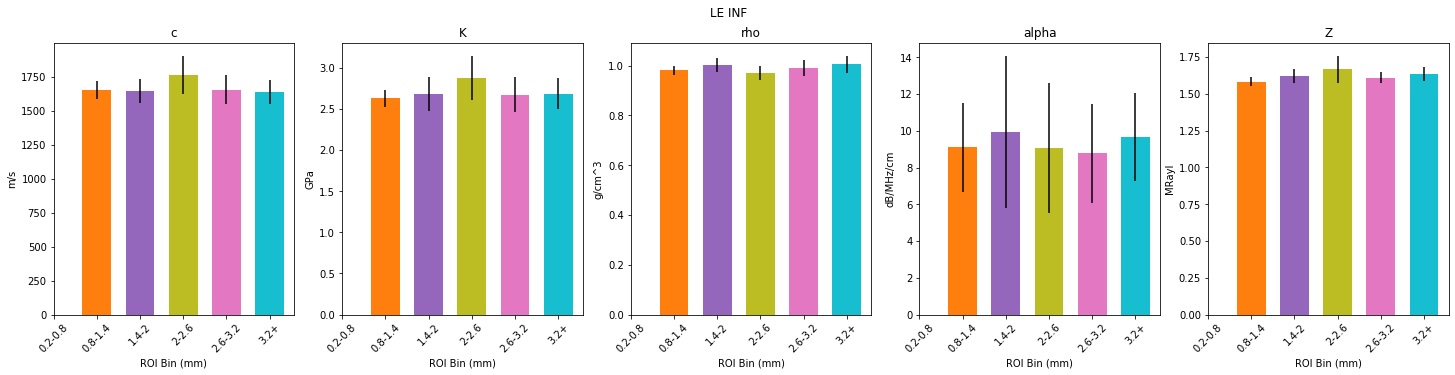

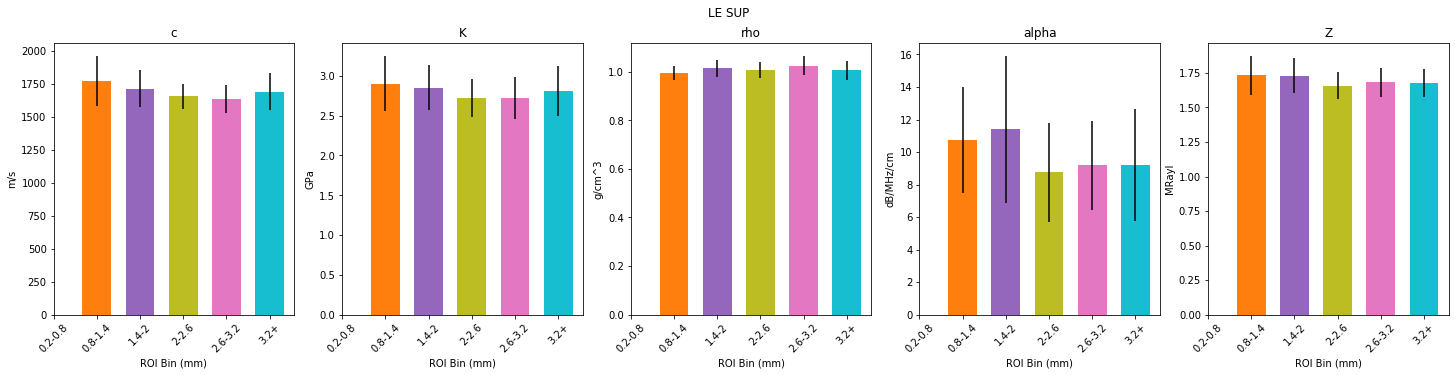

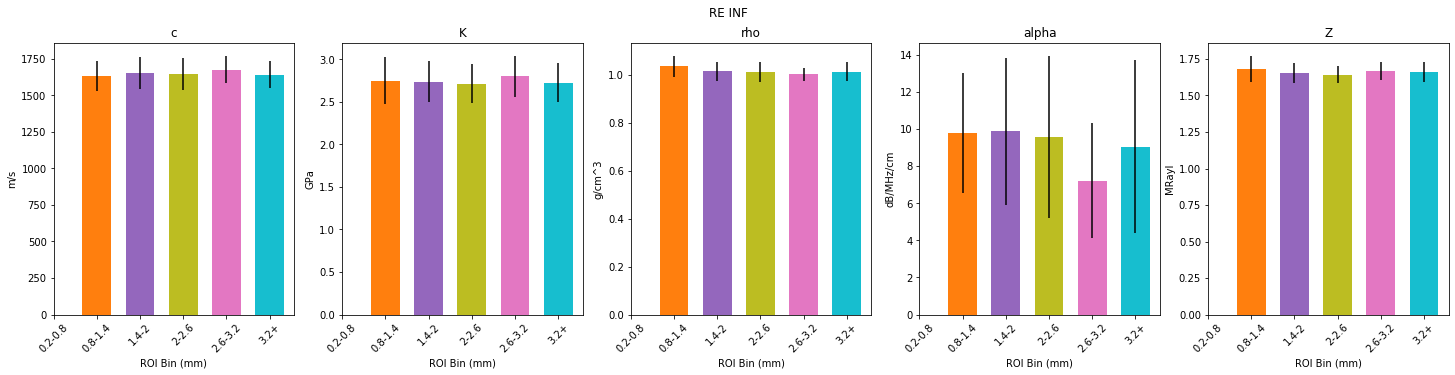

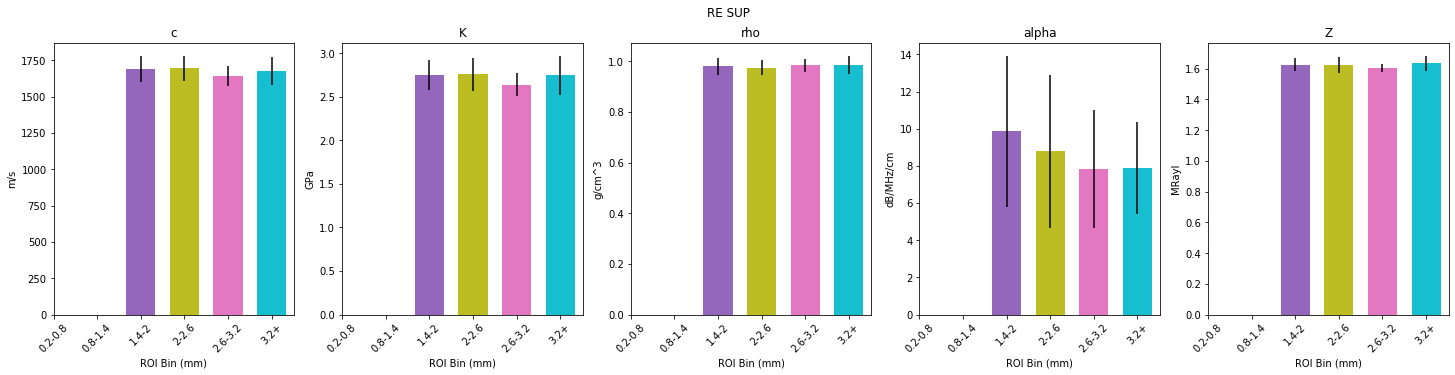

In [110]:
# Perform ANOVA for the mean parameter values as a function of distance from ROI
# Jump straight to looking at INF/SUP regions in LE/RE, so a total of 4 ANOVA for each parameter

eye_list = ['LE','RE']
reg_list = ['INF','SUP']

roi_bins = in_data.groupby('roi_bin').count().index # list of the ROI bin ranges, hopefully sorted
color_list = ['tab:blue','tab:orange','tab:purple','tab:olive','tab:pink','tab:cyan','tab:red']

b_width = 0.3
num_bins = len(roi_bins)
x_pos = np.linspace(-num_bins/2,num_bins/2,num_bins)

temp_df_list = []

for ee, this_eye in enumerate(eye_list):
    for rr, this_reg in enumerate(reg_list):
        this_df = in_data[in_data['Eye'] == this_eye]
        this_df = this_df[this_df['Region'] == this_reg]
        temp_res = np.zeros((num_param,2))

        this_fig, this_ax = plt.subplots(1,num_param,figsize=((5*num_param,5)))
        this_ax = this_ax.ravel()

        for pp, this_param in enumerate(param_list): # loop over the acoustic parameters list
            # Add lists of parameter values in each ROI bin to a master list
            this_data_list = []
            this_data_list = [this_df[this_df['roi_bin'] == x][this_param] for x in roi_bins]

            # Group for plotting purposes
            p_y = this_df.groupby('roi_bin')[this_param].mean().values
            p_bins = this_df.groupby('roi_bin').mean().index
            p_err = this_df.groupby('roi_bin')[this_param].std().values

            this_ax[pp].bar(x=x_pos,height=p_y,yerr=p_err,color=color_list)
            this_ax[pp].set_xticks(x_pos)
            this_ax[pp].set_xticklabels(roi_bins,rotation=45)
            this_ax[pp].set_xlabel('ROI Bin (mm)')
            this_ax[pp].set_ylabel(units_list[pp])
            this_ax[pp].set_title(this_param)

            # Remove any empty lists
            copy_list = []
            bin_list = []
            for ll in range(len(this_data_list)):
                if len(this_data_list[ll]) > 0:
                    copy_list.append(this_data_list[ll])
                    bin_list.append(roi_bins[ll])
            

            this_f, this_p = scipy.stats.f_oneway(*copy_list) # the '*' is used to unpack the argument list
            temp_res[pp,:] = [this_f,this_p]

            fit_y = this_df.groupby('ROI',as_index=False).mean()[this_param].values.reshape((-1,1))
            fit_x = this_df.groupby('ROI',as_index=False).mean()['ROI'].values.reshape((-1,1))

            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fit_x.ravel(),fit_y.ravel())

        this_fig.suptitle(f"{this_eye} {this_reg}")
        
        save_str = f"param_by_roi_{this_eye}_{this_reg}.png"

        this_fig.savefig(save_str,dpi=200,bbox_inches='tight')
        
        temp_df = pd.DataFrame(temp_res,columns=['f-stat','p-value'],index=param_list)
        temp_df.columns = pd.MultiIndex.from_product([[this_eye+' '+this_reg], temp_df.columns])

        temp_df_list.append(temp_df.copy())


full_df = pd.concat(temp_df_list,axis=1)

display(full_df)
    


This is the first comparison of the parameters as a function of distance from ONH. Before looking at layers, comparing means across whole width of sclera

LE INF: c, K, rho

LE SUP: none

RE INF: none 

RE SUP: none

Layer 1          Layer 2              Layer 3         Layer 4  \
              f-stat p-value   f-stat     p-value   f-stat p-value  f-stat   
LE INF c      0.8349  0.5146   4.5151  6.1071e-03   5.1949  0.0029  5.0890   
       K      1.8741  0.1429   1.7735  1.6223e-01   4.8826  0.0041  4.7840   
       rho    1.7590  0.1652   2.1872  9.6292e-02   1.7135  0.1750  4.1366   
       alpha  2.3968  0.0741   0.4032  8.0466e-01   1.2095  0.3289  1.7612   
       Z      4.4348  0.0067   3.6409  1.6457e-02   2.5224  0.0634  3.2836   
LE SUP c      0.7284  0.5804   5.6417  1.9608e-03   4.8810  0.0043  0.9248   
       K      0.6497  0.6320   1.0046  4.2236e-01   4.8333  0.0045  1.1905   
       rho    0.6171  0.6541   0.9503  4.5043e-01   1.0535  0.3984  0.6313   
       alpha  2.0947  0.1092   0.1525  9.6022e-01   3.3677  0.0233  0.2658   
       Z      0.5835  0.6772   2.2946  8.5160e-02   3.9671  0.0117  1.2244   
RE INF c      0.6507  0.6297   1.3442  2.7003e-01   0.5074  0.7305  2.8298   
       K      0.9649  0.4370   1.8702  1.3406e-01   0.3513  0.8416  1.6405   
       rho    2.3695  0.0683   0.7828  5.4292e-01   0.2342  0.9175  2.2936   
       alpha  1.0284  0.4042   1.1198  3.6040e-01   1.2245  0.3153  0.4463   
       Z      1.8946  0.1297   1.9753  1.1634e-01   0.0914  0.9846  0.4126   
RE SUP c      2.4501  0.1138   0.8648  4.8588e-01   3.6240  0.0453  0.2714   
       K      2.4121  0.1175   1.6683  2.2640e-01  16.5694  0.0001  0.2969   
       rho    1.9879  0.1696   0.4692  7.0927e-01   0.0854  0.9667  0.2147   
       alpha  0.8620  0.4872  22.6404  3.1364e-05   0.5748  0.6424  1.0771   
       Z      0.7462  0.5451   1.5532  2.5181e-01   6.0621  0.0094  0.3797   

                      
             p-value  
LE INF c      0.0033  
       K      0.0046  
       rho    0.0093  
       alpha  0.1648  
       Z      0.0251  
LE SUP c      0.4641  
       K      0.3375  
       rho    0.6444  
       alpha  0.8974  
       Z      0.3237  
RE INF c      0.0371  
       K      0.1830  
       rho    0.0761  
       alpha  0.7744  
       Z      0.7985  
RE SUP c      0.8448  
       K      0.8270  
       rho    0.8843  
       alpha  0.3956  
       Z      0.7694

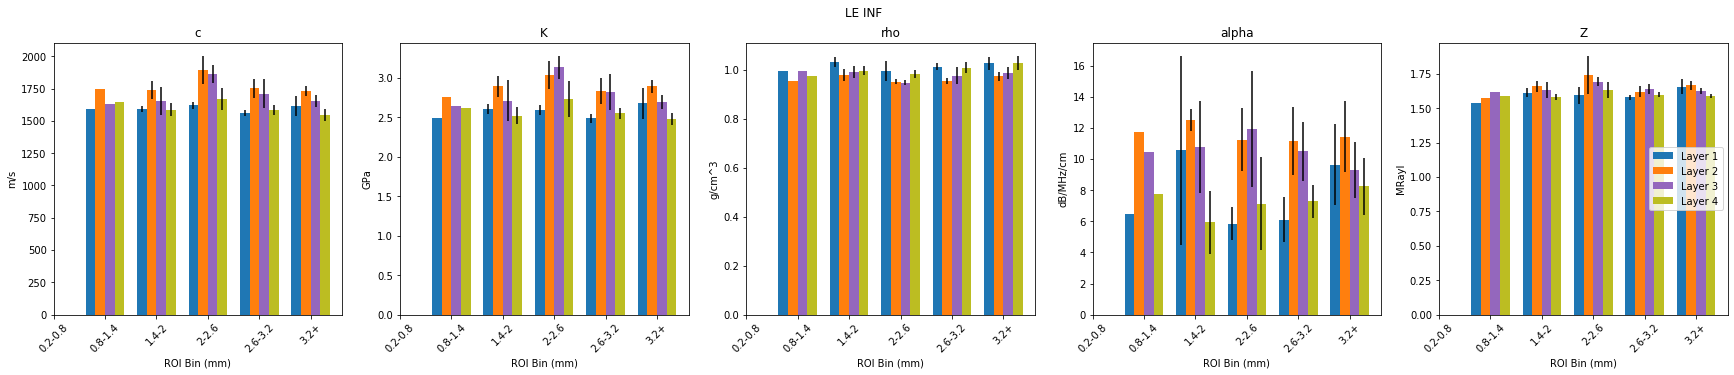

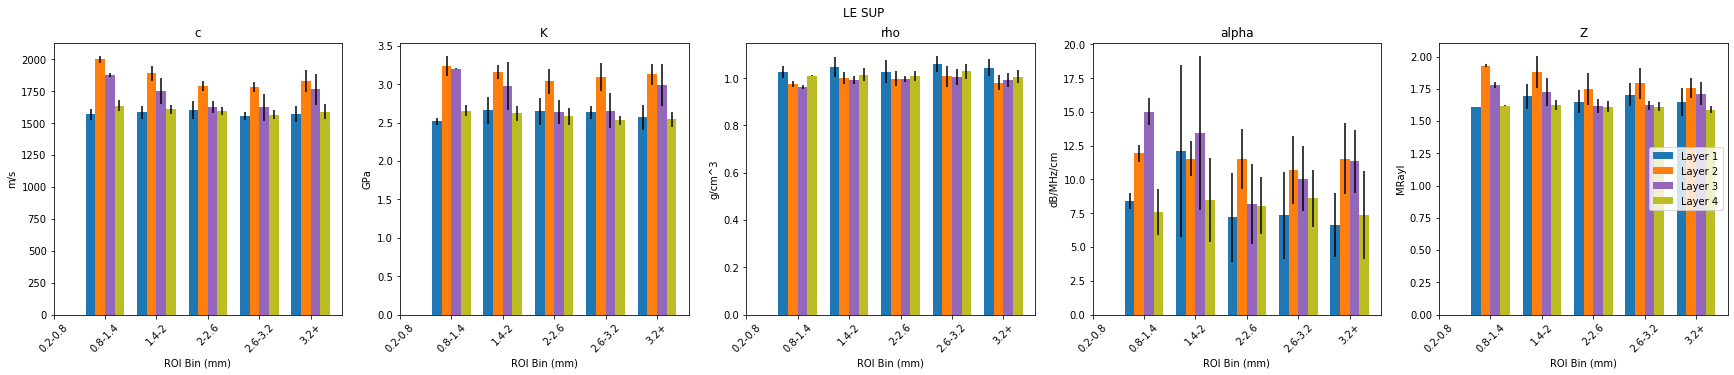

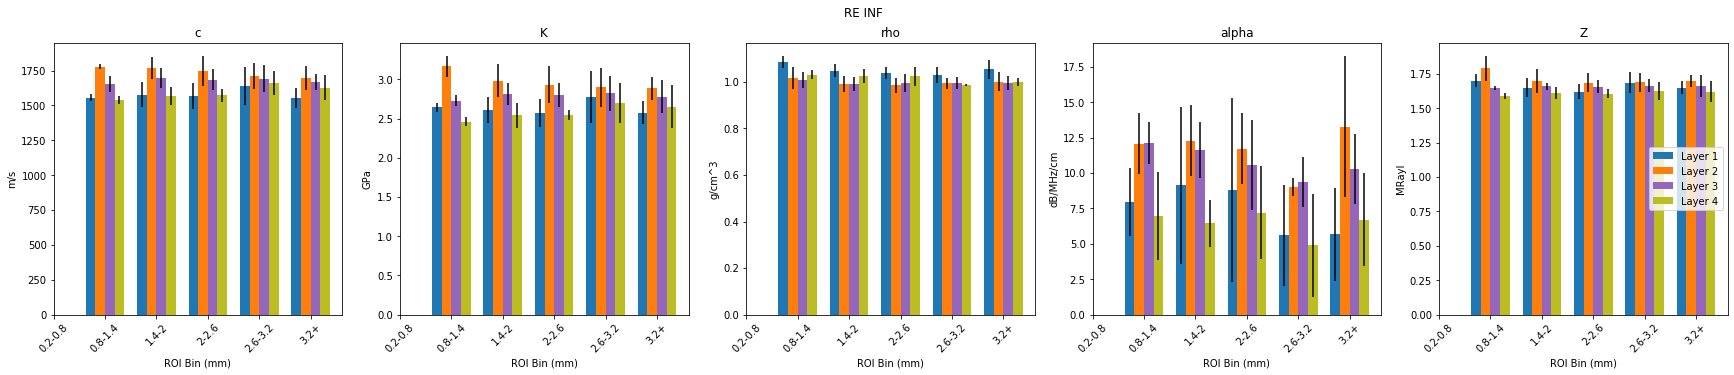

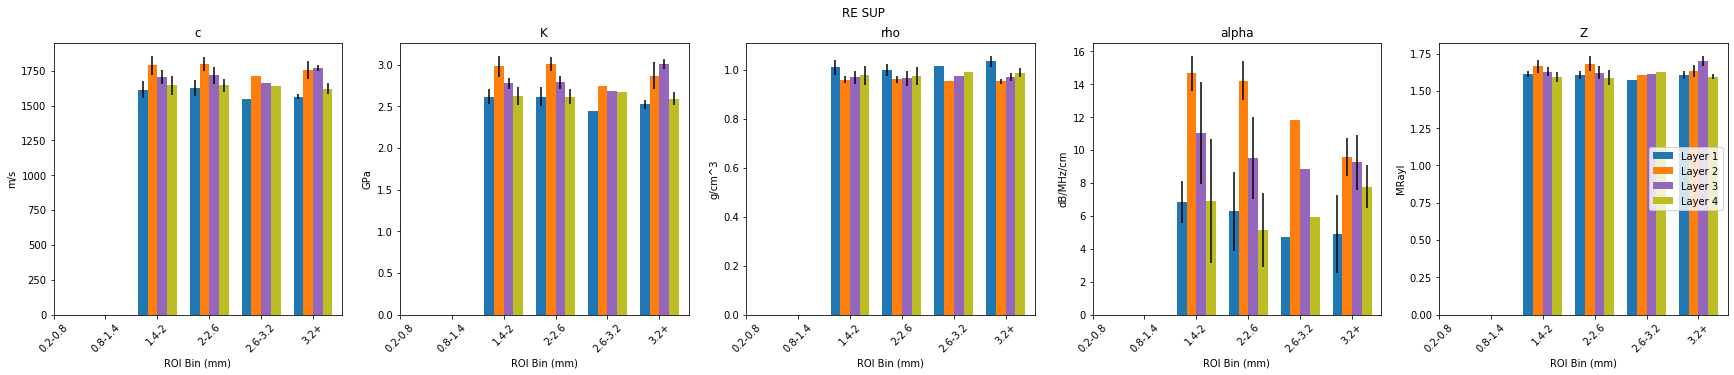

In [64]:
# Let's try the above again, but this time splitting each ROI bin into layers as well

eye_list = ['LE','RE']
reg_list = ['INF','SUP']

roi_bins = in_data.groupby('roi_bin').count().index # list of the ROI bin ranges, hopefully sorted
color_list = ['tab:blue','tab:orange','tab:purple','tab:olive','tab:pink','tab:cyan','tab:red']

b_width = 0.225 # divide by 4 to fit bars for each layer into the space
num_bins = len(roi_bins)
x_pos = np.linspace(-num_bins/2,num_bins/2,num_bins)
x_offsets = np.asarray([-1.5, -0.5, 0.5, 1.5])
temp_df_list = []

for ee, this_eye in enumerate(eye_list):
    for rr, this_reg in enumerate(reg_list):
        this_df = in_data[in_data['Eye'] == this_eye]
        this_df = this_df[this_df['Region'] == this_reg]
        temp_res = np.zeros((num_param,2))

        this_fig, this_ax = plt.subplots(1,num_param,figsize=((6*num_param,5)))
        this_ax = this_ax.ravel()

        temp_layer_df = []
        for ll in range(4): # Loop over the layers
            for pp, this_param in enumerate(param_list): # loop over the acoustic parameters list

                layer_df = this_df[this_df['Layer'] == (ll+1)]

                # Add lists of parameter values in each ROI bin to a master list
                this_data_list = []
                this_data_list = [layer_df[layer_df['roi_bin'] == x][this_param] for x in roi_bins]


                # Determine the center points of the bars based on the position of the group within the figure
                this_bar_x = x_pos + x_offsets[ll]*b_width

                # Group for plotting purposes
                p_y = layer_df.groupby('roi_bin')[this_param].mean().values
                p_err = layer_df.groupby('roi_bin')[this_param].std().values

                this_ax[pp].bar(x=this_bar_x,height=p_y,yerr=p_err,width=b_width,color=color_list[ll])
                this_ax[pp].set_xticks(x_pos)
                this_ax[pp].set_xticklabels(roi_bins,rotation=45)
                this_ax[pp].set_xlabel('ROI Bin (mm)')
                this_ax[pp].set_ylabel(units_list[pp])
                this_ax[pp].set_title(this_param)

                # Remove any empty lists
                copy_list = []
                bin_list = []
                for cc in range(len(this_data_list)):
                    if len(this_data_list[cc]) > 0:
                        copy_list.append(this_data_list[cc])
                        bin_list.append(roi_bins[cc])
                

                this_f, this_p = scipy.stats.f_oneway(*copy_list) # the '*' is used to unpack the argument list
                temp_res[pp,:] = [this_f,this_p]
            
            temp_df = pd.DataFrame(temp_res,columns=['f-stat','p-value'],index=param_list)
            temp_df.columns = pd.MultiIndex.from_product([[f'Layer {ll+1}'], temp_df.columns])

            temp_layer_df.append(temp_df.copy())

        temp_df = pd.concat(temp_layer_df,axis=1)
        temp_df.index = pd.MultiIndex.from_product([[this_eye+' '+this_reg], temp_df.index])
        temp_df_list.append(temp_df.copy())

        this_ax[-1].legend(['Layer 1','Layer 2','Layer 3','Layer 4'],loc='center right')
        this_fig.suptitle(f"{this_eye} {this_reg}")

        save_str = f"param_by_layer_roi_{this_eye}_{this_reg}.png"

        this_fig.savefig(save_str,dpi=200,bbox_inches='tight')
        
        temp_df = pd.DataFrame(temp_res,columns=['f-stat','p-value'],index=param_list)
        

        


full_df = pd.concat(temp_df_list,axis=0)

display(full_df)
    

This one is a lot to take in. Once again comparing the acoustic parameters within each layer as a function of distance from ONH, splitting into LE/RE and Inf/Sup. 

LE INF

    - Layer 1: Z
    - Layer 2: c
    - Layer 3: c, K
    - Layer 4: c, K, rho, Z

LE SUP

    - Layer 1: None
    - Layer 2: c
    - Layer 3: c, K, alpha, Z
    - Layer 4: None

RE INF

    - Layer 1: None
    - Layer 2: None
    - Layer 3: None
    - Layer 4: c

LE SUP

    - Layer 1: None
    - Layer 2: None
    - Layer 3: c, K, Z
    - Layer 4: None

[2.6-3.2, 2.6-3.2, 2.6-3.2, 2.6-3.2, 2.6-3.2, ..., 2-2.6, 2-2.6, 2-2.6, 2-2.6, 2-2.6]
Length: 507
Categories (6, object): [0.2-0.8 < 0.8-1.4 < 1.4-2 < 2-2.6 < 2.6-3.2 < 3.2+]